In [1]:
import os
from joblib import dump, load
import pickle
import sys
sys.path.insert(0, os.path.join(os.getcwd(),os.pardir))
from collections import Counter
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem.lancaster import LancasterStemmer
from mpl_toolkits.mplot3d import Axes3D

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

In [2]:
svc = load("best_linearSVC.joblib")

In [3]:
FILES  = ["train","val","test"]
FOLDER = os.path.join(os.getcwd(),os.pardir,"recipe_1m_analysis","data")
file = FILES[0]

In [4]:
enc = load("scikit_vocab_cuisine.joblib")

In [5]:
with open(os.path.join(FOLDER,"recipe1m_"+file+".pkl"),"rb") as f:
    data = pickle.load(f)

In [6]:
len(data)

268012

In [7]:
ingr_input = [";".join([ingr.name for ingr in recipe["ingredients"]]) for recipe in data.values() ]

In [8]:
vocab = load("scikit_vocab.joblib")

In [9]:
len(vocab)

70554

In [10]:
cv = CountVectorizer(vocabulary=vocab)
X = cv.fit_transform(ingr_input)

In [11]:
prediction = svc.predict(X)
len(prediction)

268012

In [12]:
str_pred =enc.inverse_transform(prediction)

In [13]:
counter_svc=Counter(str_pred)

In [14]:
len(str_pred)

268012

In [15]:
for i,v in enumerate(data.values()):
    v["cuisine"]=str_pred[i]
    
    if i<50:
        print(v["title"],v["cuisine"])

['dilly', 'macaroni', 'salad', 'recipe'] NorthAmerican
['gazpacho'] NorthAmerican
['cool', "'", 'n', 'easy', 'creamy', 'watermelon', 'pie'] NorthAmerican
['kombu', 'tea', 'grilled', 'chicken', 'thigh'] NorthAmerican
['pink', 'sangria'] NorthAmerican
['pineapple', 'loaf'] NorthAmerican
['tinklee', "'s", 'vanilla', 'crack'] NorthAmerican
['erin', "'s", 'mashed', 'potatoes'] NorthAmerican
['banana', 'cream', 'pie', 'smoothie'] NorthAmerican
['frosty', 'lemon', 'ice', 'cream', 'sandwiches'] NorthAmerican
['apple', 'cinnamon', 'french', 'toast', 'strata'] NorthAmerican
['margarita', 'madras'] NorthAmerican
['lobster', 'on', 'the', 'barbie'] NorthAmerican
['penne', 'with', 'smoked', 'trout', 'and', 'sugar', 'snap', 'peas'] NorthAmerican
['cheesy', 'herbed', 'egg', 'sandwich'] NorthAmerican
['balsamic', 'chicken', 'pasta', 'with', 'fresh', 'cheese'] SouthernEuropean
['chirashi', '(', 'scattered', ')', 'sushi'] NorthAmerican
['hot', 'corned', 'beef', 'buns'] NorthAmerican
['creme', 'curd', 'cu

In [16]:
#95% pred
threshold=0.95
y_pred_prob = svc.predict_proba(X)
max_prob = y_pred_prob.max(axis=1)
y_pred = y_pred_prob.argmax(axis=1)

to_del = np.argwhere(max_prob < threshold).T[0]

partial_y_pred = np.delete(y_pred,to_del)
partial_y_pred

array([6, 6, 6, ..., 6, 6, 6], dtype=int64)

In [17]:
len(partial_y_pred)

7250

In [18]:
Counter(partial_y_pred)

Counter({6: 7032, 4: 117, 10: 89, 8: 4, 1: 6, 11: 2})

In [19]:
with open(os.path.join(FOLDER,"recipe1m_"+file+"_cuisine_svc.pkl"), "wb") as f:
    pickle.dump(data, f)

## Load NN classified file

In [20]:
with open(os.path.join(FOLDER,"recipe1m_"+file+"_cuisine_nn.pkl"),"rb") as f:
    data_nn = pickle.load(f)

In [21]:
with open(os.path.join(os.getcwd(),"results","vocab_cuisine.pkl"), "rb") as f:
    vocab_cuisine = pickle.load(f)

In [22]:
for el in counter_svc.keys():
    vocab_cuisine.add_word(el)

In [23]:
vocab_cuisine.word2idx

{'NorthAmerican': 0,
 'SouthernEuropean': 1,
 'LatinAmerican': 2,
 'Asian': 3,
 'WesternEuropean': 4,
 'SouthAsian': 5,
 'SoutheastAsian': 6,
 'EastAsian': 7,
 'African': 8,
 'MiddleEastern': 9,
 'EasternEuropean': 10,
 'NorthernEuropean': 11}

In [24]:
counter_nn=Counter([recp["cuisine"] for recp in data_nn.values()])

In [61]:
coherence_matrix = np.zeros((len(counter_nn),len(counter_svc)),dtype=np.int)
np.set_printoptions(suppress=True)
for idx,recp in data_nn.items():
    coherence_matrix[vocab_cuisine.word2idx[recp["cuisine"]]][vocab_cuisine.word2idx[data[idx]["cuisine"]]]+=1
print(coherence_matrix[0][0])
coherence_matrix[0][0]=14000

202492


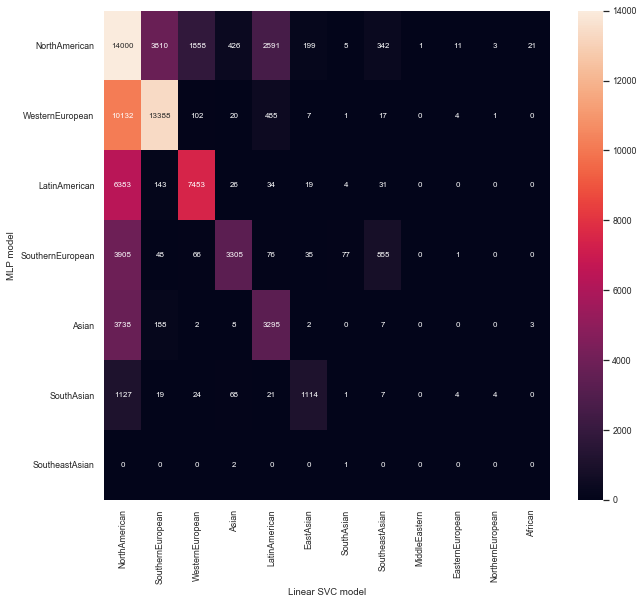

In [40]:
df_cm = pd.DataFrame(coherence_matrix, index = counter_nn.keys(),
                  columns = counter_svc.keys())
plt.figure(figsize=(10,9))
#sn.set(font_scale=0.8) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, fmt='g') # font size
plt.xlabel("Linear SVC model")
plt.ylabel("MLP model")
plt.show()


In [52]:
a=0.95

In [53]:
str(a)*bool(a)

'0.95'

In [64]:
np.trace(coherence_matrix)-14000+202492

231048

In [65]:
231048/len(data)

0.8620808023521335

In [55]:
with open(os.path.join(FOLDER,"recipe1m_"+file+"_cuisine_nn0.95.pkl"),"rb") as f:
    data_nn95 = pickle.load(f)

In [58]:
predicted = [recp["cuisine"] for recp in data_nn95.values() if "cuisine" in recp]

In [59]:
len(predicted)

60967

In [60]:
Counter(predicted)

Counter({'NorthAmerican': 56636,
         'SouthernEuropean': 3868,
         'LatinAmerican': 419,
         'SouthAsian': 39,
         'WesternEuropean': 5})

In [62]:
len(data)

268012